<a href="https://colab.research.google.com/github/ridhimagarg/PyTorchBook/blob/main/Chapter04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# from data_generation.image_classification import generate_dataset
from image_classification import generate_dataset ##  if working on  colab 
from v0 import StepByStep
# from plot.chapter4 import * 
from chapter4 import *
# from stepbystep.v0 import StepByStep

## Data Generation

In [4]:
## lets generate 300
images, labels = generate_dataset(img_size=5, n_images=300, seed=13)

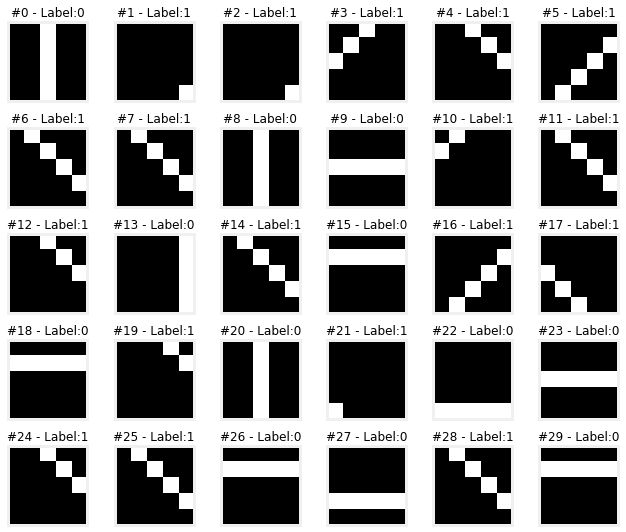

In [5]:
fig = plot_images(images, labels, n_plot=30)

In [6]:
## Images  and channels

image_r = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128
image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128
image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

In [7]:
image_r

array([[255, 128,   0,   0,   0],
       [255, 128,   0,   0,   0],
       [255, 128,   0,   0,   0],
       [255, 128,   0,   0,   0],
       [255, 128,   0,   0,   0]], dtype=uint8)

In [8]:
image_g

array([[  0, 128, 255, 128,   0],
       [  0, 128, 255, 128,   0],
       [  0, 128, 255, 128,   0],
       [  0, 128, 255, 128,   0],
       [  0, 128, 255, 128,   0]], dtype=uint8)

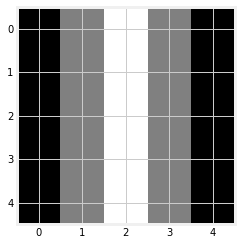

In [9]:
plt.imshow(image_g, cmap="gray")
plt.show()

In [10]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2)
print(image_rgb)

[[[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]]


In [11]:
images.shape

(300, 1, 5, 5)

In [12]:
example = images[7]

In [13]:
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

In [14]:
## In pytorch, we use channels, height, width
## so for PIL, we have to transpose to height, width, channels.
example_hwc = np.transpose(example, (1, 2, 0))
example_hwc.shape


(5, 5, 1)

In [16]:
## Converting the nump array to pytorch array.
tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [18]:
example_tensor
## this time value is not 255, may be totensor changes the scale range

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [21]:
## To visualize the images, lets convert it to PIL Image

example_img = ToPILImage()(example_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


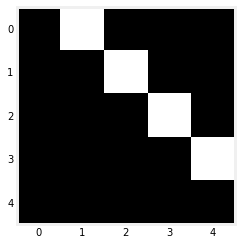

In [22]:
plt.imshow(example_img, cmap="gray")
plt.grid(False)

## Transform images

In [26]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

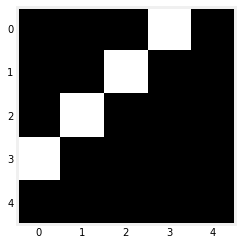

In [27]:
plt.imshow(flipped_img, cmap="gray")
plt.grid(False)

In [28]:
## Lets convert the flipped image into tensor first

In [29]:
img_tensor = tensorizer(flipped_img)
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [30]:
## Min max scaler using 0.5 as mean and std deviation

normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)
normalized_tensor


tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])